In [10]:
import re
import pandas as pd
import numpy as np
import h5py
import torch
from torch.utils.data import Dataset
from scipy.signal import butter, filtfilt, resample
from typing import Tuple
import matplotlib.pyplot as plt


from BedrettoDataset import BedrettoDataset
from phasenet import PhaseNet

In [2]:
dataset = BedrettoDataset(csv_file='..\\data\\train\\metadata.csv', h5_file='..\\data\\train\\waveforms.hdf5')
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
    
model = PhaseNet().to(device)

epochs = 50
learning_rate = 3e-2

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [21]:
# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs, logits=True)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.cpu().detach().numpy() / inputs.shape[0]
        if (not i%10):
            print(f"Iteration {i}/{len(train_loader)}, Loss: {train_loss / (i+1)}")  # print mean training loss so far
            
    print(f"End of Epoch mean training loss {train_loss / len(train_loader)}")
            
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs, logits=True)
            val_loss += criterion(outputs, labels) / inputs.shape[0]
        
        print(f'Validation loss for epoch {epoch+1}: ', val_loss / len(val_loader))

Iteration 0/110, Loss: 0.02938873879611492
Iteration 10/110, Loss: 0.011581343006003986
Iteration 20/110, Loss: 0.007509134122214857
Iteration 30/110, Loss: 0.00608827646130756
Iteration 40/110, Loss: 0.005306674366271714
Iteration 50/110, Loss: 0.004730551581208904
Iteration 60/110, Loss: 0.00426732751418699
Iteration 70/110, Loss: 0.003899204607029826
Iteration 80/110, Loss: 0.0036104166158762428
Iteration 90/110, Loss: 0.0033818644926893516
Iteration 100/110, Loss: 0.0031868462522265197
End of Epoch mean training loss 0.003046859692231837
Validation loss for epoch 1:  tensor(0.0014)
Iteration 0/110, Loss: 0.0013292775256559253
Iteration 10/110, Loss: 0.001369491505267268
Iteration 20/110, Loss: 0.001376116631685623
Iteration 30/110, Loss: 0.0013496529408580354
Iteration 40/110, Loss: 0.0013442602059690327
Iteration 50/110, Loss: 0.0013393577594565703
Iteration 60/110, Loss: 0.0013306005896053842
Iteration 70/110, Loss: 0.0013225256763792165
Iteration 80/110, Loss: 0.0013173522189098

C:\Users\tolga\AppData\Local\Temp\ipykernel_9232\2258609426.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(model.forward(inputs, logits=True))


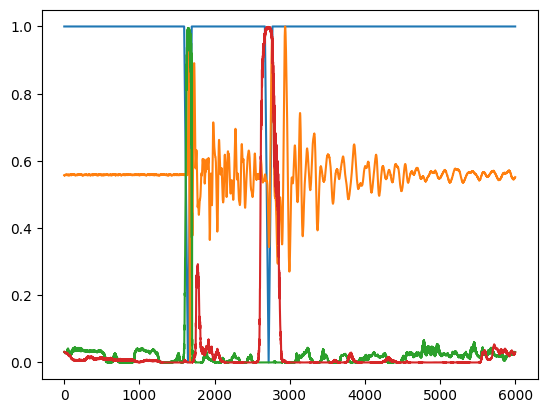

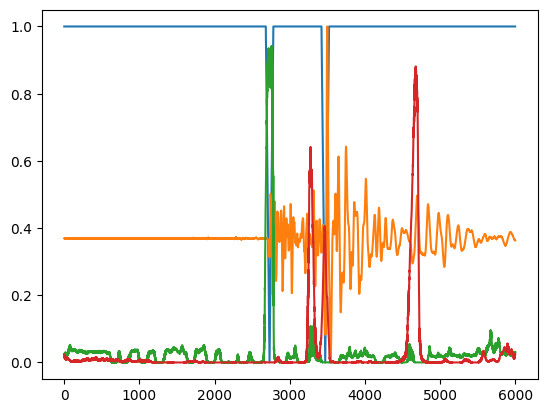

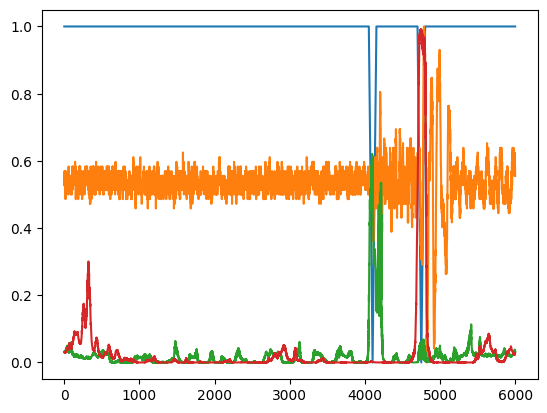

In [22]:
batch_num = 2
with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
        if (i > 0):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = torch.nn.functional.softmax(model.forward(inputs, logits=True))
            plt.plot(labels.cpu().detach().numpy()[batch_num, 2, :])
            plt.plot(inputs.cpu().detach().numpy()[batch_num, 0])
            plt.plot(outputs.cpu().detach().numpy()[batch_num,0,:])
            plt.plot(outputs.cpu().detach().numpy()[batch_num,1,:])
            plt.show()
            if (i == 3): break